In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [3]:
def compute_mvc_2d(
        src_pts, 
        cage_pts, 
        eps=1e-12
    ):
    """
    Compute 2D Mean Value Coordinates for points inside a polygonal cage.
    TODO: for loop -> compute it as batch

    Args:
        src_pts (np.ndarray): (V, 2) points inside the cage 
        cage_pts (np.ndarray): (Nc, 2) cage vertices (counter-clockwise)
        eps (np.ndarray): small number
        
    Returns:
        W (np.ndarray): (V, Nc) MVC weights (rows sum to 1)
    """
    V = src_pts.shape[0]
    Nc = cage_pts.shape[0]
    W = np.zeros((V, Nc), dtype=np.float64)
    
    # Pre-compute edges indices
    idx_next = np.arange(Nc) + 1
    idx_next[-1] = 0
    
    for vi in range(V):
        x = src_pts[vi]  # (2,)

        # Vectors from x to polygon vertices
        d = cage_pts - x[None, :]          # (Nc, 2)
        r = np.linalg.norm(d, axis=1)      # (Nc,)
        
        # Handle exact vertex hit
        j = np.argmin(r)
        if r[j] < eps:
            e = np.zeros(Nc); e[j] = 1.0
            W[vi] = e
            continue
        
        # Unit directions
        u = d / r[:, None]                 # (Nc, 2)
        
        # Angles between successive directions
        u_next = u[idx_next]               # (Nc, 2)
        dot = (u * u_next).sum(axis=1)     # (Nc,)
        dot = np.clip(dot, -1.0, 1.0)
        alpha = np.arccos(dot)             # (Nc,)
        
        # If x lies on an edge == linear interpolation
        # on_edge = np.isclose(alpha, 0.0, atol=1e-12)
        on_edge = np.isclose(alpha, np.pi, atol=1e-12)
        if np.any(on_edge):
            
            k = int(np.where(on_edge)[0][0])
            i0, i1 = k, idx_next[k]
            v0, v1 = cage_pts[i0], cage_pts[i1]

            seg = v1 - v0
            t = np.dot(x - v0, seg) / (np.dot(seg, seg) + eps)
            t = np.clip(t, 0.0, 1.0)
            e = np.zeros(Nc)
            e[i0] = 1.0 - t
            e[i1] = t
            W[vi] = e
            continue
        
        # Compute half-angle tangents
        sin_a = np.sin(alpha)
        tan_half = sin_a / (1.0 + np.cos(alpha) + eps)  # (Nc,)
        
        # MVC numerator term
        tan_prev = tan_half[np.arange(Nc) - 1]
        w = (tan_prev + tan_half) / (r + eps)
        
        # Normalize
        s = np.sum(w)

        if s < eps:
            w = np.ones(Nc) / Nc
        else:
            w = w / s
        
        W[vi] = w
    
    return W


In [20]:
# Create cage 
theta = np.linspace(0, 2*np.pi, 6)[:-1] + 0.2

radius = np.array([1.0, 0.8, 1.3, 0.9, 1.0])

cage = np.stack([radius*np.cos(theta), radius*np.sin(theta)], axis=1)  # (5,2)
print(cage)

[[ 0.98006658  0.19866933]
 [ 0.09112917  0.79479272]
 [-1.18256505  0.53994436]
 [-0.60850405 -0.66311599]
 [ 0.49180299 -0.87070651]]


In [21]:
### just for visualization!!!!
# Generate a grid 
xmin, ymin = cage.min(axis=0) - 0.2
xmax, ymax = cage.max(axis=0) + 0.2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # (M,2)

### pick points inside polygon
path = Path(cage)
mask_inside = path.contains_points(grid)

# interior points
src = grid[mask_inside]

In [22]:
# Compute MVC weights
W = compute_mvc_2d(src, cage)

# Deform the cage (move vertices)
rng = np.random.default_rng(0)
deform = cage.copy()
displacement = rng.normal(scale=0.25, size=deform.shape)
print(displacement)
deform += displacement

# Map interior points using MVC
dst = W @ deform  # (len(src), 2)

[[ 0.03143256 -0.03302622]
 [ 0.16010566  0.02622503]
 [-0.13391734  0.09039876]
 [ 0.32600001  0.23677024]
 [-0.17593381 -0.31635537]]


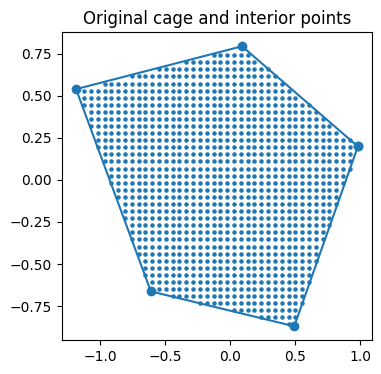

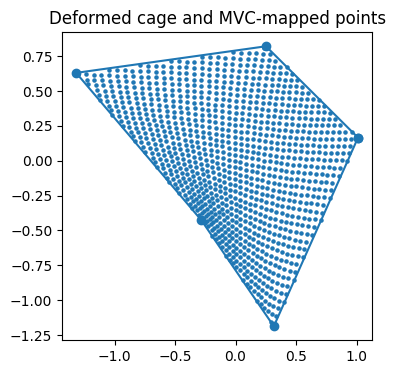

0.9999999999999997 1.0000000000000004 1.0


In [23]:



# 1) Original cage + interior samples
SIZE=4
plt.figure(figsize=(SIZE,SIZE))
plt.plot(*np.vstack([cage, cage[0]]).T, '-o')
plt.scatter(src[:,0], src[:,1], s=5)
plt.title("Original cage and interior points")
# plt.gca().set_aspect('equal', 'box')
plt.show()

# 2) Deformed cage + mapped points
plt.figure(figsize=(SIZE,SIZE))
plt.plot(*np.vstack([deform, deform[0]]).T, '-o')
plt.scatter(dst[:,0], dst[:,1], s=5)
plt.title("Deformed cage and MVC-mapped points")
# plt.gca().set_aspect('equal', 'box')
plt.show()

sum_rows = np.sum(W, axis=1)
print(np.min(sum_rows), np.max(sum_rows), np.mean(sum_rows))

In [69]:
def bilinear_sample(img, xy):
    H, W, C = img.shape
    x = xy[:,0]
    y = xy[:,1]
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    out = (Ia * wa[:,None] + Ib * wb[:,None] + Ic * wc[:,None] + Id * wd[:,None])
    return out

# Create procedural RGB image
H, W = 360, 480
yy, xx = np.meshgrid(np.linspace(0,1,H), np.linspace(0,1,W), indexing='ij')
img = np.zeros((H, W, 3), dtype=np.float32)
img[...,0] = xx
img[...,1] = yy
img[...,2] = (np.sin(6*np.pi*xx)*np.cos(4*np.pi*yy)+1) #* 0.5
print(img.shape)


# Source cage (octagon)
pad = 10.0
src_cage = np.array([
    [pad, pad],
    [W/2, 0+pad],
    [W-pad, pad],
    [W-pad, H/2],
    [W-pad, H-pad],
    [W/2, H-pad],
    [pad, H-pad],
    [pad, H/2],
], dtype=np.float64)

# Deformed cage
deform = src_cage.copy() * 0.8
deform[1] += np.array([-80,  30])
deform[3] += np.array([-20, -10])
deform[5] += np.array([-60, -30])
deform[7] += np.array([ 30, -20])


(360, 480, 3)


In [70]:
## grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
path = Path(deform)
inside = path.contains_points(grid)
pts_tgt = grid[inside]
pts_tgt_out = grid[~inside]

In [71]:
# deformation
W_mvc = compute_mvc_2d(pts_tgt, deform)
pts_src = W_mvc @ src_cage

# Backward mapping
rgb = bilinear_sample(img, pts_src[:, [0,1]])
warped = np.zeros_like(img)

## HW flatten
warped.reshape(-1,3)[inside] = rgb


In [72]:

W_mvc_out = compute_mvc_2d(pts_tgt_out, deform)
pts_src_out = W_mvc_out @ src_cage

rgb_out = bilinear_sample(img, pts_src_out[:, [0,1]])
## HW flatten
warped.reshape(-1,3)[~inside] = rgb_out

In [73]:
cooord_bfr = img.copy()#[:,:,::-1]
cooord_bfr[:,:,2] = 0

cooord_aft = warped.copy()#[:,:,::-1]
cooord_aft[:,:,2] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


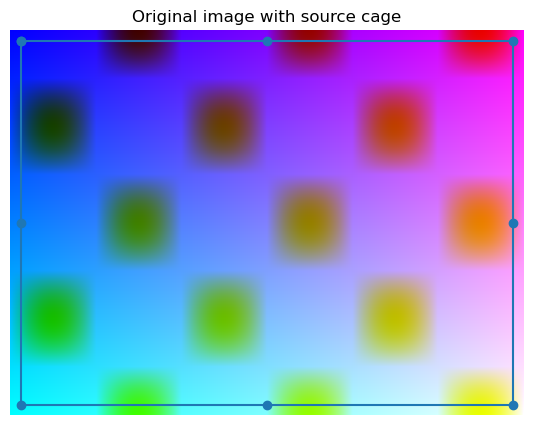

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


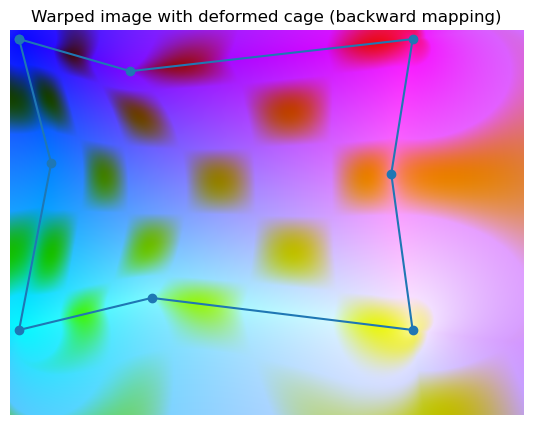

In [74]:


# Visualize
plt.figure(figsize=(7,5))
plt.imshow(img)
plt.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
plt.title("Original image with source cage")
plt.axis('off')
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(warped)
plt.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
plt.title("Warped image with deformed cage (backward mapping)")
plt.axis('off')
plt.show()


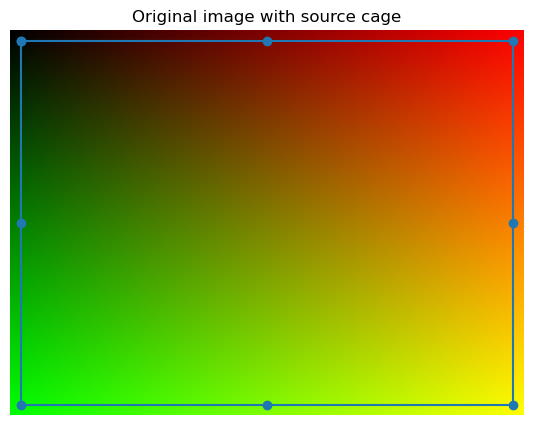

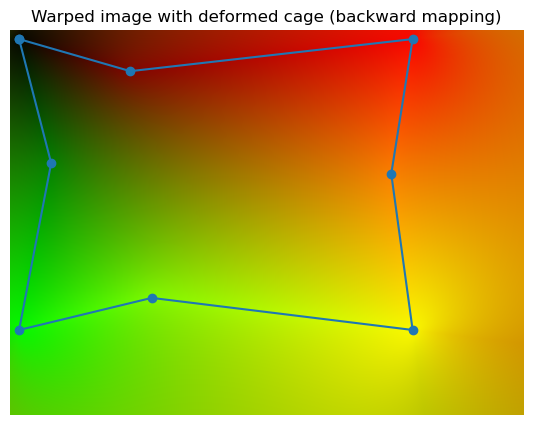

In [ ]:


# Visualize
plt.figure(figsize=(7,5))
plt.imshow(cooord_bfr)
plt.plot(np.r_[src_cage[:,0], src_cage[0,0]], np.r_[src_cage[:,1], src_cage[0,1]], '-o')
plt.title("Original coordinate with source cage")
plt.axis('off')
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(cooord_aft)
plt.plot(np.r_[deform[:,0], deform[0,0]], np.r_[deform[:,1], deform[0,1]], '-o')
plt.title("Warped coordinate with deformed cage (backward mapping)")
plt.axis('off')
plt.show()
